## **Importing all the modules**

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import ftfy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import tensorflow 
from math import exp
from numpy import sign
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors #used for word2vec 
from nltk.corpus import stopwords
from nltk import PorterStemmer
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

**Declaring the Constants**

In [ ]:
np.random.seed(1234)
DEPRES_NROWS = 3200  # number of rows to read from DEPRESSIVE_TWEETS CSV
RANDOM_NROWS = 12000 # number of rows to read from RANDOM_TWEETS CSV
MAX_SEQUENCE_LENGTH = 140 # Maximum tweet size
MAX_NB_WORDS = 20000 #Maximum number of words to consider as feature for tokenizer
EMBEDDING_DIM = 300 #Size of the embedding vector (GoogleNews-vectors-negative300.bin)
TRAIN_SPLIT = 0.6 
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1 #eta(n)
EPOCHS= 10

**Loading the datasets**

Tweets dataset

In [ ]:
RANDOM_TWEETS_CSV='/Sentiment Analysis Dataset 2.csv' #All tweets
DEPRESSIVE_TWEETS_CSV='/depressive_tweets_processed.csv' #Tweets that are indicative of depression scrapped from Twitter using Twint

Keyed Vectors needed for Word2Vec

In [ ]:
EMBEDDING_FILE = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz'

Reading the files into dataframes and displaying 

In [ ]:
depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV, sep = '|', header = None, usecols = range(0,9), nrows = DEPRES_NROWS)
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV, encoding = "ISO-8859-1", usecols = range(0,4), nrows = RANDOM_NROWS)
depressive_tweets_df.head()

,0,1,2,3,4,5,6,7,8
0,989292962323615744,2018-04-25,23:59:57,Eastern Standard Time,whosalli,The lack of this understanding is a small but ...,1,0,3
1,989292959844663296,2018-04-25,23:59:56,Eastern Standard Time,estermnunes,i just told my parents about my depression and...,1,0,2
2,989292951716155392,2018-04-25,23:59:54,Eastern Standard Time,TheAlphaAries,depression is something i don't speak about ev...,0,0,0
3,989292873664393218,2018-04-25,23:59:35,Eastern Standard Time,_ojhodgson,Made myself a tortilla filled with pb&j. My de...,1,0,0
4,989292856119472128,2018-04-25,23:59:31,Eastern Standard Time,DMiller96371630,@WorldofOutlaws I am gonna need depression med...,0,0,0


In [ ]:
random_tweets_df.head()

,ï»¿ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


**Preprocessing** 

Done to remove any links,images,mentions,emojis,punctuations,expand contractions like Won't to will not, stem words so they are all the same tense 

In [ ]:
#dictionary that contains the key:value pairs as the contraction:word
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))
#function to replace all the contractions with the corresponding words
def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

**Cleaning the dataset**

In [ ]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # url links are avoided as most are news articles
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:  # tweet length is checked against the length of "depression" i.e.10
            #below line removes hashtags, mentions, emojis and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            tweet = ftfy.fix_text(tweet)
            tweet = expandContractions(tweet)
            #below code is used to remove punctuations
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

            #below code is used to remove common stop words like articles,prepositions,conjunctions and pronouns
            stop_words = set(stopwords.words('english')) #using the natural language toolkit
            word_tokens = nltk.word_tokenize(tweet)  #breaking the raw tweets into smaller chunks 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)
            #stemming words
            tweet = PorterStemmer().stem(tweet)
            cleaned_tweets.append(tweet)
    return cleaned_tweets

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#sending each dataitem of the 2 datasets into the preprocessing clean function
depressive_tweets_arr = [x for x in depressive_tweets_df[5]]
random_tweets_arr = [x for x in random_tweets_df['SentimentText']]
X_d = clean_tweets(depressive_tweets_arr) 
X_r = clean_tweets(random_tweets_arr)

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS) #breaks the raw text into tokens to understand the context
tokenizer.fit_on_texts(X_d + X_r)

In [ ]:
#transforming the texts into sequences of integers
sequences_d = tokenizer.texts_to_sequences(X_d) 
sequences_r = tokenizer.texts_to_sequences(X_r)

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 21548 unique tokens


In [ ]:
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_d tensor: (2308, 140)
Shape of data_r tensor: (11911, 140)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True) #detects synonymous words

In [ ]:
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [ ]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

#Arrays are split into test data (60%), validation data (20%), and train data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]
perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combining the 2 arrays and generating random permutations for shuffling
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

**Defining the hyperparameters of the model**

In [ ]:
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 300)          6000000   
                                                                 
 conv1d (Conv1D)             (None, 140, 32)           28832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 70, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 70, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 300)               399600    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                        

**Training the model**

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3) #to prevent overfitting

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=40, shuffle=True, \
        callbacks=[early_stop])

Epoch 1/10
214/214 [==============================] - 108s 484ms/step - loss: 0.1532 - acc: 0.9488 - val_loss: 0.0366 - val_acc: 0.9909
Epoch 2/10
214/214 [==============================] - 120s 561ms/step - loss: 0.0453 - acc: 0.9892 - val_loss: 0.0358 - val_acc: 0.9916
Epoch 3/10
214/214 [==============================] - 118s 554ms/step - loss: 0.0352 - acc: 0.9906 - val_loss: 0.0303 - val_acc: 0.9926
Epoch 4/10
214/214 [==============================] - 119s 555ms/step - loss: 0.0275 - acc: 0.9928 - val_loss: 0.0370 - val_acc: 0.9916
Epoch 5/10
214/214 [==============================] - 124s 578ms/step - loss: 0.0227 - acc: 0.9938 - val_loss: 0.0347 - val_acc: 0.9923
Epoch 6/10
214/214 [==============================] - 119s 556ms/step - loss: 0.0240 - acc: 0.9933 - val_loss: 0.0347 - val_acc: 0.9923


**Summaries of the model**

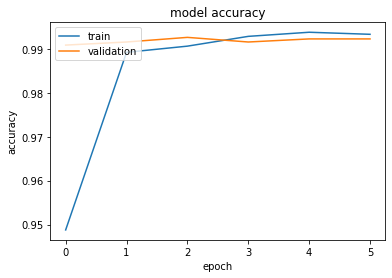

In [ ]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

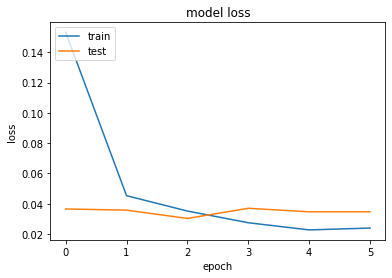

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

89/89 [==============================] - 14s 152ms/step
Accuracy: 99.05%


In [ ]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2382
           1       0.99      0.95      0.97       462

    accuracy                           0.99      2844
   macro avg       0.99      0.98      0.98      2844
weighted avg       0.99      0.99      0.99      2844



Most CNNs use ReLU at the activation layer and either sigmoid or tanh at the hidden layers. Building the model using tanh makes it more inaccurate. Above model gives us the best accuracy.

In [57]:
model2= Sequential()
# Embedded layer
model2.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model2.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.2))
# LSTM Layer
model2.add(LSTM(300))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='tanh'))

In [58]:
model2.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 140, 300)          6000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 140, 32)           28832     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 70, 32)           0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 70, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 300)               399600    
                                                                 
 dropout_5 (Dropout)         (None, 300)               0         
                                                      

In [59]:
early_stop = EarlyStopping(monitor='val_loss', patience=3) #to prevent overfitting

hist = model2.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=40, shuffle=True, \
        callbacks=[early_stop])

Epoch 1/10
214/214 [==============================] - 83s 371ms/step - loss: 0.1522 - acc: 0.9676 - val_loss: 0.0656 - val_acc: 0.9884
Epoch 2/10
214/214 [==============================] - 84s 393ms/step - loss: 0.3714 - acc: 0.9407 - val_loss: 0.0797 - val_acc: 0.9905
Epoch 3/10
214/214 [==============================] - 78s 367ms/step - loss: 0.0840 - acc: 0.9904 - val_loss: 0.0679 - val_acc: 0.9916
Epoch 4/10
214/214 [==============================] - 77s 358ms/step - loss: 0.0760 - acc: 0.9925 - val_loss: 0.0802 - val_acc: 0.9916


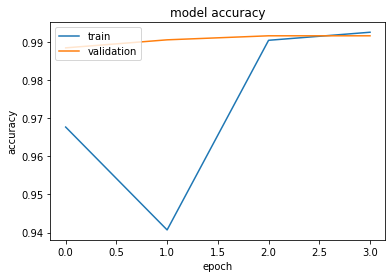

In [60]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [61]:
labels_pred = model2.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

89/89 [==============================] - 8s 82ms/step
Accuracy: 18.92%


**Comparing it with a Logistic Regression Model**

In [ ]:
class LogReg:
    def __init__(self, l_rate, epochs, n_features):
        self.l_rate = l_rate
        self.epochs = epochs
        self.coef = [0.0] * n_features
        self.bias = 0.0

    def sigmoid(self, score, threshold=20.0):
        if abs(score) > threshold:
            score = threshold * sign(score)
        activation = exp(score)
        return activation / (1.0 + activation)

    def predict(self, features):
        value = sum([features[i]*self.coef[i] for i in range(len(features))]) + self.bias
        return self.sigmoid(value)

    def sg_update(self, features, label):
        yhat = self.predict(features)
        e = label - yhat
        self.bias = self.bias + self.l_rate * e * yhat * (1-yhat)
        for i in range(len(features)):
            self.coef[i] = self.coef[i] + self.l_rate * e * yhat * (1-yhat) * features[i]
        return

    def train(self, X, y):
        for epoch in range(self.epochs):
            for features, label in zip(X, y):
                self.sg_update(features, label)
        return self.bias, self.coef

def get_accuracy(y_bar, y_pred):
    correct = 0
    for i in range(len(y_bar)):
        if y_bar[i] == y_pred[i]:
            correct += 1
    accuracy = (correct / len(y_bar)) * 100.0
    return accuracy
#training 
logreg = LogReg(LEARNING_RATE, EPOCHS, len(data_train[0]))
bias_logreg, weights_logreg = logreg.train(data_train, labels_train)
y_logistic = [round(logreg.predict(example)) for example in data_test]
#summary
accuracy_logistic = get_accuracy(y_logistic, labels_test)
print('Logistic Regression Accuracy: {:0.2f}'.format(accuracy_logistic))

Logistic Regression Accuracy: 83.76
